In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import pickle
import graphviz
import itertools
import time
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback

import pickle

from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder


from google.colab import drive
# drive.mount('/content/drive')

# with open('/content/drive/My Drive/full_dataset_one_hot_encoded (1).pkl', 'rb') as f:  #this is the debugging dataset so we may want to replace with full dataset
#   df = pickle.load(f)

# print(df)
# print(df.columns)

In [ ]:



#https://drive.google.com/file/d/1pEK8HoH-V0xHgHTN5HMUcrOs16fkAXuj/view?usp=drive_link
file_id = '1pEK8HoH-V0xHgHTN5HMUcrOs16fkAXuj'
destination = 'full_dataset_one_hot_encoded (1).pkl'
# Use the correct URL format for gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1pEK8HoH-V0xHgHTN5HMUcrOs16fkAXuj
From (redirected): https://drive.google.com/uc?id=1pEK8HoH-V0xHgHTN5HMUcrOs16fkAXuj&confirm=t&uuid=7bf68dc5-b3fc-4826-96a8-d244f9ed307c
To: /content/full_dataset_one_hot_encoded (1).pkl
100%|██████████| 1.37G/1.37G [00:16<00:00, 85.6MB/s]


'full_dataset_one_hot_encoded (1).pkl'

# (1) Deep Learning Model Construction for Dataset

In [ ]:
#TRIM DATA TO A SUBSET TO AVOID CRASHING
with open(destination, 'rb') as file:
    df = pickle.load(file)
print(df.columns)
df = df.sample(frac=1, random_state=92).reset_index(drop=True)
n=25000
df = df[:n].dropna()

Index(['INSPECTION_TYPE', 'BBL', 'BORO_CODE', 'BLOCK', 'LOT', 'HOUSE_NUMBER',
       'STREET_NAME', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 'LATITUDE',
       'LONGITUDE', 'BOROUGH', 'INSPECTION_DATE', 'RESULT', 'LOCATION',
       'COMMUNITY BOARD', 'COUNCIL DISTRICT', 'CENSUS TRACT', 'NTA', 'MONTH',
       'REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED',
       'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


In [ ]:
df['INSPECTION_DATE'] = pd.to_datetime(df['INSPECTION_DATE'], format='%m/%d/%Y %I:%M:%S %p')
df_sorted = df.sort_values(by='INSPECTION_DATE')
df_sorted.reset_index(drop=True, inplace=True)

In [ ]:
from re import A
df_sorted['STREET_ADDRESS'] = df_sorted['HOUSE_NUMBER'].astype(str) + ' ' + df_sorted['STREET_NAME']
unique_address = df_sorted['STREET_ADDRESS'].unique()
print(unique_address.shape[0])

df_sorted['HAD_PAST_INSPECTION'] = 0

for address in unique_address:
  repeated_add = df_sorted[df_sorted['STREET_ADDRESS'] == address].index   #df_sorted.loc[df_sorted['STREET_ADDRESS'] == unique_address[ii]].iloc[1:]
  if len(repeated_add) > 1:
    df_sorted.loc[repeated_add[1:], 'HAD_PAST_INSPECTION'] = 1


df = df_sorted.sample(frac=1, random_state=42).reset_index(drop=True)

22705


In [ ]:
# Find columns that are of type 'object' (typically strings in pandas)
string_columns = df.select_dtypes(include=['object']).columns
print("Columns with string data:", string_columns)


inspection_type_coded = pd.get_dummies(df['INSPECTION_TYPE']) #converting to one hot encoding bc sklearn doesn't like strings
df = pd.concat([df, inspection_type_coded],axis=1)

print(df.columns)

# Check columns by type
datetime_columns = df.select_dtypes(include=['datetime']).columns
numeric_columns = df.select_dtypes(include=['number']).columns
bool_columns = df.select_dtypes(include=['bool']).columns
print("Columns with datetime data:", datetime_columns)
print("Columns with numeric data:", numeric_columns)
print("Columns with boolean data:", bool_columns)

# Convert datetime columns to numeric
for col in datetime_columns:
    df[col] = df[col].astype('int64') // 10**9  # Converts to seconds since epoch as integer


# Convert boolean columns to integers
for col in bool_columns:
  df[col] = df[col].astype(int)

Columns with string data: Index(['INSPECTION_TYPE', 'HOUSE_NUMBER', 'STREET_NAME', 'BOROUGH', 'RESULT',
       'LOCATION', 'NTA', 'STREET_ADDRESS'],
      dtype='object')
Index(['INSPECTION_TYPE', 'BBL', 'BORO_CODE', 'BLOCK', 'LOT', 'HOUSE_NUMBER',
       'STREET_NAME', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 'LATITUDE',
       'LONGITUDE', 'BOROUGH', 'INSPECTION_DATE', 'RESULT', 'LOCATION',
       'COMMUNITY BOARD', 'COUNCIL DISTRICT', 'CENSUS TRACT', 'NTA', 'MONTH',
       'REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED',
       'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'STREET_ADDRESS', 'HAD_PAST_INSPECTION', 'Compliance', 'Initial'],
      dtype='object')
Columns with datetime data: Index(['INSPECTION_DATE'], dtype='object')
Columns with numeric data: Index(['BBL', 'BORO_CODE', 'BLOCK', 'LOT', 'ZIP_CO

In [ ]:
df['RESULT'].unique()

array(['Passed', 'Rat Activity', 'Failed for Other R'], dtype=object)

# **Embedded Learning**

Street address is a string so it cannot be used in the deep learning. We are trying embedded learning so that we don't loose information when we drop street address.

Resource - https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/

In [ ]:
df['STREET_ADDRESS'] = df['HOUSE_NUMBER'].astype(str) + ' ' + df['STREET_NAME']

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
# Integer encode the address data

label_encoder = LabelEncoder()
integer_encoded_address = label_encoder.fit_transform(df['STREET_ADDRESS'])
print(integer_encoded_address)

# define vocabulary size (number of unique words)
vocab_size = len(label_encoder.classes_)

# define the length of the embedded vector for each word
embedding_dim = 8  # Adjust this based on your data and model complexity

# create an embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=1)

# Reshape the encoded addresses to fit the embedding layer (samples, word_index)
integer_encoded_address = integer_encoded_address.reshape(-1, 1)

# Get the embedded representations of the addresses
embedded_addresses = embedding_layer(tf.constant(integer_encoded_address))
print("Embedded Addresses Shape:", embedded_addresses.shape)

# Convert the embedded addresses to a NumPy array and add to the DataFrame
embedded_addresses_array = embedded_addresses.numpy()

# Create new columns in the dataframe for the embedding vectors
for i in range(embedding_dim):
    df[f'ADDRESS_EMBEDDING_{i}'] = embedded_addresses_array[:, 0, i]


[ 5658 15503 19369 ... 12706 22561  1761]
Embedded Addresses Shape: (25000, 1, 8)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **Feature Crossing **

Resource:https://krishna-yogik.medium.com/feature-cross-a-deep-dive-with-practical-examples-4e87a373f117

In [ ]:
#we are trying to cross the x and y coordinates
df['X_Y_interaction'] = df['X_COORD'] * df['Y_COORD']

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
X = df.drop(columns=['RESULT', 'STREET_NAME', 'BOROUGH', 'INSPECTION_TYPE',
                     'HOUSE_NUMBER', 'NTA', 'LOCATION', 'INSPECTION_DATE', 'STREET_ADDRESS'])


df['RESULT'] = df['RESULT'].map({'Passed': 0, 'Failed for Other R': 1, 'Rat Activity': 2})


y = df['RESULT']

In [ ]:
df['RESULT'].unique()

array([0, 2, 1])

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=82)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# to categorical
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(17500, 45)
(17500, 3)


In [ ]:

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'val_accuracy'])


In [ ]:
class CustomLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Log every 100 epochs
            print(f"Epoch {epoch + 1}: Loss = {logs['loss']}, Accuracy = {logs['accuracy']}, Validation Accuracy = {logs['val_accuracy']}")

# (2) Investigate the Effect of Mini-Batch Learning

In [ ]:
#Batch size
from google.colab import drive

# Experiment with mini-batch sizes
batch_sizes = [32]
initial_weights = model.get_weights()


for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.set_weights(initial_weights)  # Reset to initial weights
    history32 = model.fit(X_train, y_train, epochs=3000, batch_size=batch_size, validation_split=0.3, verbose=0,callbacks=[CustomLogger()])

    #drive.mount('/content/drive')

    #model.save('/content/drive/My Drive/model_batchsize32')


Training with batch size: 32
Epoch 100: Loss = 0.3815615773200989, Accuracy = 0.8487346768379211, Validation Accuracy = 0.6064761877059937
Epoch 200: Loss = 0.30340245366096497, Accuracy = 0.8807346820831299, Validation Accuracy = 0.5954285860061646
Epoch 300: Loss = 0.254817932844162, Accuracy = 0.9003265500068665, Validation Accuracy = 0.5935238003730774
Epoch 400: Loss = 0.22153088450431824, Accuracy = 0.9122449159622192, Validation Accuracy = 0.5790476202964783
Epoch 500: Loss = 0.21191035211086273, Accuracy = 0.9203265309333801, Validation Accuracy = 0.584761917591095
Epoch 600: Loss = 0.18831981718540192, Accuracy = 0.930122435092926, Validation Accuracy = 0.5744761824607849
Epoch 700: Loss = 0.18215824663639069, Accuracy = 0.9306122660636902, Validation Accuracy = 0.5754285454750061
Epoch 800: Loss = 0.15538883209228516, Accuracy = 0.9411428570747375, Validation Accuracy = 0.5788571238517761
Epoch 900: Loss = 0.14511577785015106, Accuracy = 0.945306122303009, Validation Accuracy

In [ ]:
drive.mount('/content/drive')

model.save('/content/drive/My Drive/model_batchsize32_548.keras')

In [ ]:
print(history32.history['val_accuracy'])

[0.7181249856948853, 0.7143750190734863, 0.7225000262260437, 0.7168750166893005, 0.7200000286102295, 0.7206249833106995, 0.7118750214576721, 0.7162500023841858, 0.7149999737739563, 0.7099999785423279, 0.7124999761581421, 0.6868749856948853, 0.7099999785423279, 0.7024999856948853, 0.6918749809265137, 0.7099999785423279, 0.6812499761581421, 0.699999988079071, 0.6931250095367432, 0.6856250166893005, 0.6825000047683716, 0.6881250143051147, 0.6837499737739563, 0.6631249785423279, 0.6650000214576721, 0.6862499713897705, 0.6493750214576721, 0.6462500095367432, 0.6468750238418579, 0.6643750071525574, 0.6399999856948853, 0.6356250047683716, 0.6756250262260437, 0.6399999856948853, 0.6575000286102295, 0.6549999713897705, 0.668749988079071, 0.6274999976158142, 0.6399999856948853, 0.6381250023841858, 0.6337500214576721, 0.6518750190734863, 0.6449999809265137, 0.6225000023841858, 0.659375011920929, 0.6262500286102295, 0.628125011920929, 0.6331250071525574, 0.6312500238418579, 0.6524999737739563, 0.6

In [ ]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5787 - loss: 14.3066


[13.429182052612305, 0.5824999809265137]

In [ ]:
plt.figure(figsize=(10, 6))
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

N=200
plt.plot(moving_average(history32.history['accuracy']), label='Training Accuracy for Batch_size = 32')
plt.plot(moving_average(history32.history['val_accuracy']), label='Validation Accuracy for Batch_size = 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Batch size


# Experiment with mini-batch sizes
batch_sizes = [16, 32, 64]
initial_weights = model.get_weights()


for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.set_weights(initial_weights)  # Reset to initial weights
    if batch_size == 16:
      history16 = model.fit(X_train, y_train, epochs=3000, batch_size=batch_size, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    elif batch_size == 32:
      history32 = model.fit(X_train, y_train, epochs=3000, batch_size=batch_size, validation_split=0.2,verbose=0, callbacks=[CustomLogger()])
    else:
      history64 = model.fit(X_train, y_train, epochs=3000, batch_size=batch_size, validation_split=0.2,verbose=0,callbacks=[CustomLogger()])

    #history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2, verbose=1)
#model.save('./model')

with open('history16.pkl', 'wb') as f:
    pickle.dump(history16.history, f)

with open('history32.pkl', 'wb') as f:
    pickle.dump(history32.history, f)

with open('history64.pkl', 'wb') as f:
    pickle.dump(history64.history, f)


Training with batch size: 16


KeyboardInterrupt: 

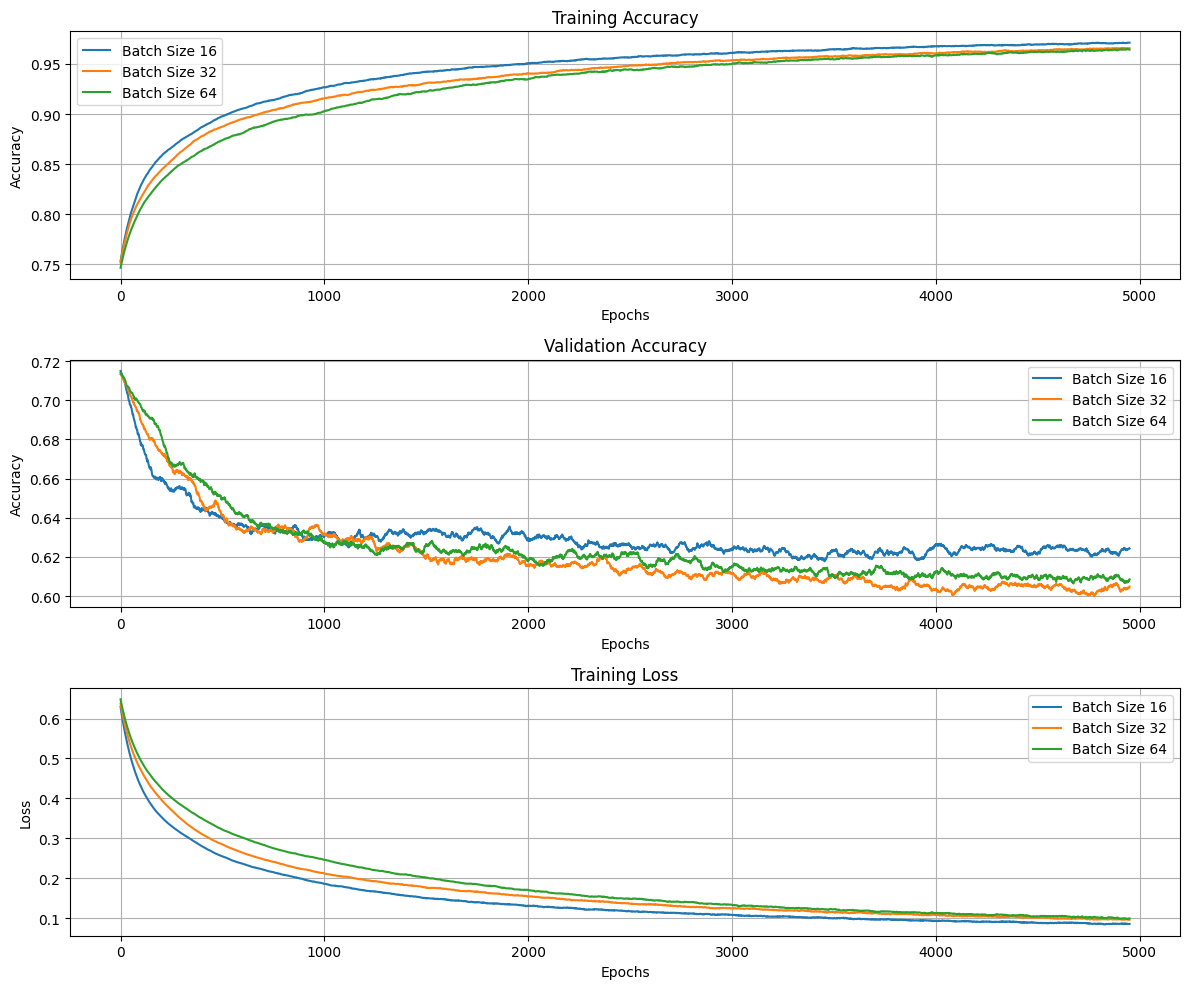

In [9]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(moving_average(history16['accuracy']), label='Batch Size 16')
plt.plot(moving_average(history32['accuracy']), label='Batch Size 32')
plt.plot(moving_average(history64['accuracy']), label='Batch Size 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(moving_average(history16['val_accuracy']), label='Batch Size 16')
plt.plot(moving_average(history32['val_accuracy']), label='Batch Size 32')
plt.plot(moving_average(history64['val_accuracy']), label='Batch Size 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(moving_average(history16['loss']), label='Batch Size 16')
plt.plot(moving_average(history32['loss']), label='Batch Size 32')
plt.plot(moving_average(history64['loss']), label='Batch Size 64')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


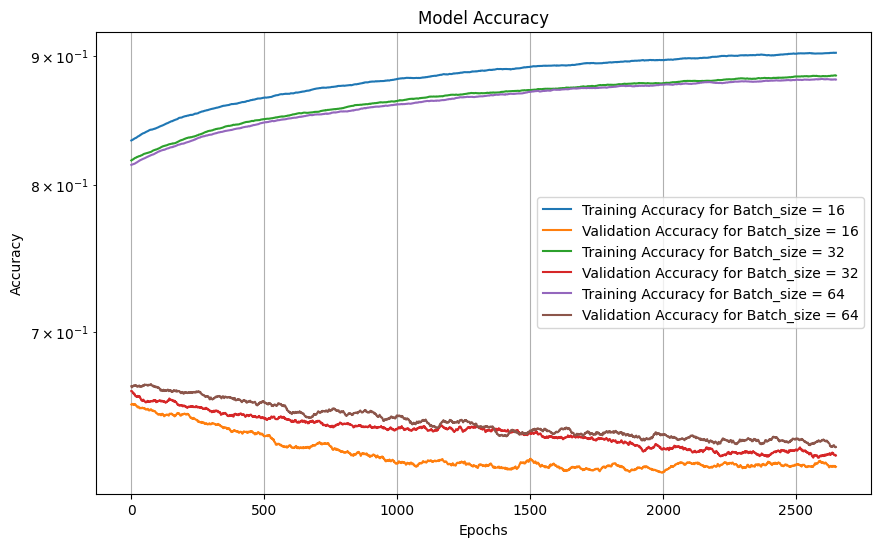

In [ ]:
plt.figure(figsize=(10, 6))
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

N=300
plt.plot(moving_average(history16.history['accuracy'][N:]), label='Training Accuracy for Batch_size = 16')
plt.plot(moving_average(history16.history['val_accuracy'][N:]), label='Validation Accuracy for Batch_size = 16')
plt.plot(moving_average(history32.history['accuracy'][N:]), label='Training Accuracy for Batch_size = 32')
plt.plot(moving_average(history32.history['val_accuracy'][N:]), label='Validation Accuracy for Batch_size = 32')
plt.plot(moving_average(history64.history['accuracy'][N:]), label='Training Accuracy for Batch_size = 64')
plt.plot(moving_average(history64.history['val_accuracy'][N:]), label='Validation Accuracy for Batch_size = 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

It looks like the validation is always worse than training accuracy for each of the batch sizes. The validation accuracy starts at around 0.65 but it lowers to 0.6 with more epochs. Since accuracy converges closer to 1, this is suggesting that our model is overfitting. A way to deal with this would be to increase the amount of data we are training on, since we are currently training on 0.2% of the total data that exists (15000 entries), since we ran into GPU hour usage limit. we imagine that it is possible by using more of the data, our model could possibly work better in not just learning the training data. We did shuffle the data in addition to make sure there was no trend in how the data was ordered since it was originally ordered by time. Between the different batch sizes, there is not a large difference since throughout the epochs each of the batch sizes fluctuate higher or lower than any of the other ones. For training however, it appears that the smaller the batch size, the higher the accuracy at each epoch.

# (3) Investigate the Effect of Different Optimizers

In [ ]:
#For this section, we take the same layer structure as applied in previous sections. The only delta between each run is the optimizer used.
#Let's perform training with 3 optimizers. (1) Adam, heavily used algorithm in pytorch. (2) SGD, our traditional gradient descent discussed in class. (3) SGD w/ momentum, a more complex version of gradient descent discussed in class that is more resilient to becoming trapped in local minima.
optimizers = [Adam(learning_rate=0.001), SGD(learning_rate=0.001, momentum=0.5), SGD(learning_rate=0.001)]

for optimizer in enumerate(optimizers):
    print(f"Training with optimizer: {optimizer[1].name}")
    model.compile(optimizer=optimizer[1], loss='categorical_crossentropy', metrics=['accuracy'])
    if optimizer[0] == 0:
      history1 = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    elif optimizer[0] == 1:
      history2 = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    else:
      history3 = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])

with open('history1.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

with open('history2.pkl', 'wb') as f:
    pickle.dump(history2.history, f)

with open('history3.pkl', 'wb') as f:
    pickle.dump(history3.history, f)



Training with optimizer: adam
Epoch 100: Loss = 0.30183470249176025, Accuracy = 0.8805208206176758
Epoch 200: Loss = 0.2898874878883362, Accuracy = 0.8876041769981384
Epoch 300: Loss = 0.29517632722854614, Accuracy = 0.8829166889190674
Epoch 400: Loss = 0.2911580801010132, Accuracy = 0.8812500238418579
Epoch 500: Loss = 0.2850266396999359, Accuracy = 0.8884375095367432
Epoch 600: Loss = 0.28532764315605164, Accuracy = 0.885937511920929
Epoch 700: Loss = 0.29338768124580383, Accuracy = 0.8858333230018616
Epoch 800: Loss = 0.2906465530395508, Accuracy = 0.8855208158493042
Epoch 900: Loss = 0.2832387387752533, Accuracy = 0.8865625262260437
Epoch 1000: Loss = 0.27884364128112793, Accuracy = 0.8883333206176758
Epoch 1100: Loss = 0.2838740646839142, Accuracy = 0.8854166865348816
Epoch 1200: Loss = 0.28298917412757874, Accuracy = 0.8882291913032532
Epoch 1300: Loss = 0.27706417441368103, Accuracy = 0.8936458230018616
Epoch 1400: Loss = 0.27968233823776245, Accuracy = 0.8891666531562805
Epoch 

In [12]:
# prompt: I would like to laod some files from Deep Dive 20/Milestone3. Specifically history1 2 and 3

import pickle

with open('/content/drive/My Drive/Deep Dive Team 20/Milestone3/history1.pkl', 'rb') as f:
    history1 = pickle.load(f)

with open('/content/drive/My Drive/Deep Dive Team 20/Milestone3/history2.pkl', 'rb') as f:
    history2 = pickle.load(f)

with open('/content/drive/My Drive/Deep Dive Team 20/Milestone3/history3.pkl', 'rb') as f:
    history3 = pickle.load(f)

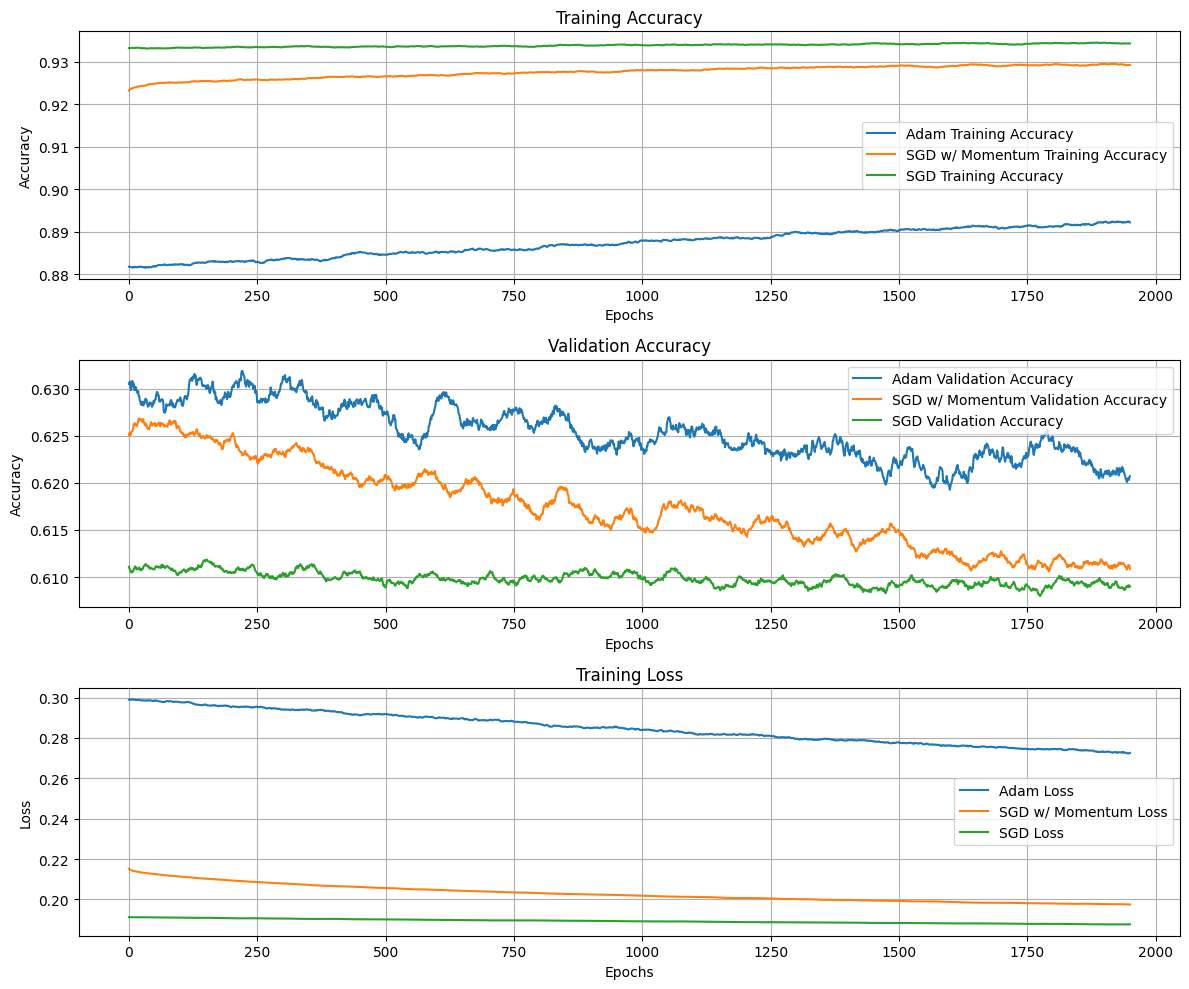

In [13]:
plt.figure(figsize=(12, 10))
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.subplot(3, 1, 1)
plt.plot(moving_average(history1['accuracy']), label='Adam Training Accuracy')
plt.plot(moving_average(history2['accuracy']), label='SGD w/ Momentum Training Accuracy')
plt.plot(moving_average(history3['accuracy']), label='SGD Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(moving_average(history1['val_accuracy']), label='Adam Validation Accuracy')
plt.plot(moving_average(history2['val_accuracy']), label='SGD w/ Momentum Validation Accuracy')
plt.plot(moving_average(history3['val_accuracy']), label='SGD Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(moving_average(history1['loss']), label='Adam Loss')
plt.plot(moving_average(history2['loss']), label='SGD w/ Momentum Loss')
plt.plot(moving_average(history3['loss']), label='SGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Clearly, we see that there is a slight increase in model accuracy and some loss reduction across epochs. This means that our model could still be slowly learning. Below, let's try modifying the model and then running optimization investigation again.

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes
])

optimizers = [Adam(learning_rate=0.001), SGD(learning_rate=0.001, momentum=0.5), SGD(learning_rate=0.001)]

for optimizer in enumerate(optimizers):
    print(f"Training with optimizer: {optimizer[1].name}")
    model.compile(optimizer=optimizer[1], loss='categorical_crossentropy', metrics=['accuracy'])
    if optimizer[0] == 0:
      history4 = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    elif optimizer[0] == 1:
      history5 = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    else:
      history6 = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])


with open('history4.pkl', 'wb') as f:
    pickle.dump(history4.history, f)

with open('history5.pkl', 'wb') as f:
    pickle.dump(history5.history, f)

with open('history6.pkl', 'wb') as f:
    pickle.dump(history6.history, f)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with optimizer: adam
Epoch 100: Loss = 0.5486620664596558, Accuracy = 0.7811458110809326
Epoch 200: Loss = 0.4763750731945038, Accuracy = 0.8089583516120911
Epoch 300: Loss = 0.42872482538223267, Accuracy = 0.8292708396911621
Epoch 400: Loss = 0.4004966616630554, Accuracy = 0.8372916579246521
Epoch 500: Loss = 0.372659295797348, Accuracy = 0.8539583086967468
Epoch 600: Loss = 0.35351836681365967, Accuracy = 0.8617708086967468
Epoch 700: Loss = 0.3326278030872345, Accuracy = 0.8683333396911621
Epoch 800: Loss = 0.32166123390197754, Accuracy = 0.8712499737739563
Epoch 900: Loss = 0.30826443433761597, Accuracy = 0.8774999976158142
Epoch 1000: Loss = 0.2986871600151062, Accuracy = 0.8821874856948853
Epoch 1100: Loss = 0.29855573177337646, Accuracy = 0.88302081823349
Epoch 1200: Loss = 0.28993603587150574, Accuracy = 0.885729193687439
Epoch 1300: Loss = 0.2816115915775299, Accuracy = 0.890625
Epoch 1400: Loss = 0.27811315655708313, Accuracy = 0.8891666531562805
Epoch 1500: Loss = 0

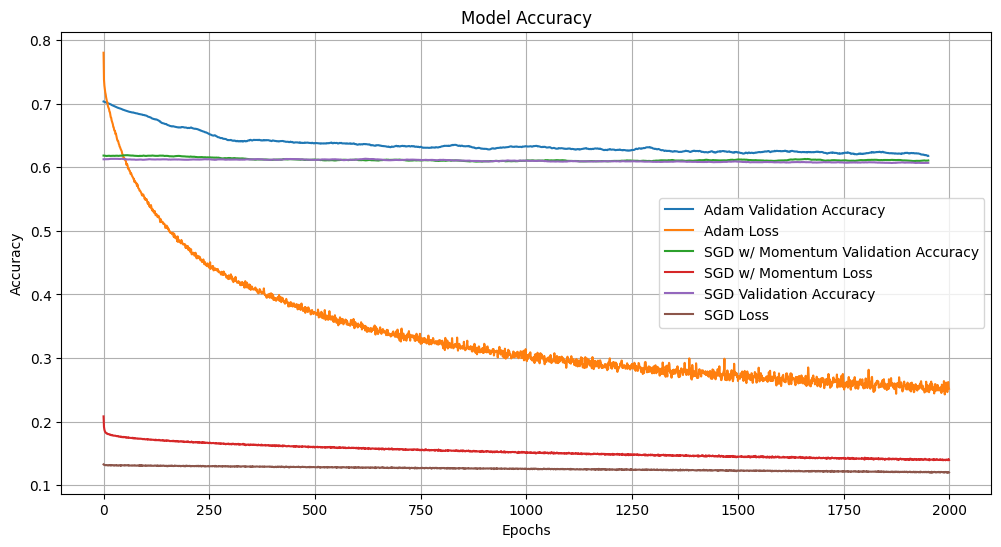

In [ ]:
plt.figure(figsize=(12, 6))
#plt.plot(history4.history['accuracy'], label='Adam Training Accuracy')
plt.plot(moving_average(history4['val_accuracy']), label='Adam Validation Accuracy')
plt.plot(history4['loss'], label='Adam Loss')
#plt.plot(history5.history['accuracy'], label='SGD w/ Momentum Training Accuracy')
plt.plot(moving_average(history5['val_accuracy']), label='SGD w/ Momentum Validation Accuracy')
plt.plot(history5['loss'], label='SGD w/ Momentum Loss')
#plt.plot(history6.history['accuracy'], label='SGD Training Accuracy')
plt.plot(moving_average(history6['val_accuracy']), label='SGD Validation Accuracy')
plt.plot(history6['loss'], label='SGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

Upon adding an additional layer, we see very little change in behavior of the system. Overall it seems ADAM is the worst in performance between the optimzation schemes since it results in the highest loss and lowest accuracy.

In [ ]:
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(3, activation='softmax')  # 3 output classes
])

optimizers = [Adam(learning_rate=0.001), SGD(learning_rate=0.001, momentum=0.5), SGD(learning_rate=0.001)]

for optimizer in enumerate(optimizers):
    print(f"Training with optimizer: {optimizer[1].name}")
    model.compile(optimizer=optimizer[1], loss='categorical_crossentropy', metrics=['accuracy'])
    if optimizer[0] == 0:
      history7 = model.fit(X_train, y_train, epochs=5000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    elif optimizer[0] == 1:
      history8 = model.fit(X_train, y_train, epochs=5000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    else:
      history9 = model.fit(X_train, y_train, epochs=5000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])


with open('history7.pkl', 'wb') as f:
    pickle.dump(history7.history, f)

with open('history8.pkl', 'wb') as f:
    pickle.dump(history8.history, f)

with open('history9.pkl', 'wb') as f:
    pickle.dump(history9.history, f)


The above code was run locally, and generated the following output -


```
Training with optimizer: adam
Epoch 100: Loss = 0.5180941820144653, Accuracy = 0.8030208349227905
Epoch 200: Loss = 0.3688316345214844, Accuracy = 0.864062488079071
Epoch 300: Loss = 0.2815299332141876, Accuracy = 0.8983333110809326
Epoch 400: Loss = 0.23388506472110748, Accuracy = 0.9162499904632568
Epoch 500: Loss = 0.20273441076278687, Accuracy = 0.9288541674613953
Epoch 600: Loss = 0.1839410662651062, Accuracy = 0.9354166388511658
Epoch 700: Loss = 0.16218283772468567, Accuracy = 0.9436458349227905
Epoch 800: Loss = 0.1431407332420349, Accuracy = 0.9492708444595337
Epoch 900: Loss = 0.1514158695936203, Accuracy = 0.9463541507720947
Epoch 1000: Loss = 0.14737990498542786, Accuracy = 0.9478124976158142
Epoch 1100: Loss = 0.11768404394388199, Accuracy = 0.9597916603088379
Epoch 1200: Loss = 0.1445295810699463, Accuracy = 0.9507291913032532
Epoch 1300: Loss = 0.10472559928894043, Accuracy = 0.9643750190734863
Epoch 1400: Loss = 0.16916075348854065, Accuracy = 0.9424999952316284
Epoch 1500: Loss = 0.12895455956459045, Accuracy = 0.9568750262260437
Epoch 1600: Loss = 0.14092211425304413, Accuracy = 0.9510416388511658
Epoch 1700: Loss = 0.09013190865516663, Accuracy = 0.9727083444595337
Epoch 1800: Loss = 0.12565436959266663, Accuracy = 0.9588541388511658
Epoch 1900: Loss = 0.10894154757261276, Accuracy = 0.9641666412353516
Epoch 2000: Loss = 0.07862155139446259, Accuracy = 0.9745833277702332
Epoch 2100: Loss = 0.09524171054363251, Accuracy = 0.9682291746139526
Epoch 2200: Loss = 0.08951670676469803, Accuracy = 0.9715625047683716
Epoch 2300: Loss = 0.1293415129184723, Accuracy = 0.9574999809265137
Epoch 2400: Loss = 0.15365462005138397, Accuracy = 0.9506250023841858
Epoch 2500: Loss = 0.09212834388017654, Accuracy = 0.9707291722297668
Epoch 2600: Loss = 0.09525169432163239, Accuracy = 0.9690625071525574
Epoch 2700: Loss = 0.1041131243109703, Accuracy = 0.965624988079071
Epoch 2800: Loss = 0.08770238608121872, Accuracy = 0.9711458086967468
Epoch 2900: Loss = 0.07729580253362656, Accuracy = 0.9765625
Epoch 3000: Loss = 0.07939523458480835, Accuracy = 0.9753124713897705
Epoch 3100: Loss = 0.07784519344568253, Accuracy = 0.9758333563804626
Epoch 3200: Loss = 0.07693741470575333, Accuracy = 0.9766666889190674
Epoch 3300: Loss = 0.06567823886871338, Accuracy = 0.9803125262260437
Epoch 3400: Loss = 0.20875532925128937, Accuracy = 0.9367708563804626
Epoch 3500: Loss = 0.10202338546514511, Accuracy = 0.9669791460037231
Epoch 3600: Loss = 0.0633978620171547, Accuracy = 0.981041669845581
Epoch 3700: Loss = 0.13223566114902496, Accuracy = 0.9569791555404663
Epoch 3800: Loss = 0.07806200534105301, Accuracy = 0.9761458039283752
Epoch 3900: Loss = 0.07706069946289062, Accuracy = 0.9758333563804626
Epoch 4000: Loss = 0.08839114010334015, Accuracy = 0.971875011920929
Epoch 4100: Loss = 0.12796837091445923, Accuracy = 0.9585416913032532
Epoch 4200: Loss = 0.0965910479426384, Accuracy = 0.96895831823349
Epoch 4300: Loss = 0.06257302314043045, Accuracy = 0.9817708134651184
Epoch 4400: Loss = 0.06260885298252106, Accuracy = 0.981249988079071
Epoch 4500: Loss = 0.15412907302379608, Accuracy = 0.9522916674613953
Epoch 4600: Loss = 0.08983570337295532, Accuracy = 0.9705208539962769
Epoch 4700: Loss = 0.0602777935564518, Accuracy = 0.9816666841506958
Epoch 4800: Loss = 0.07409697026014328, Accuracy = 0.9776041507720947
Epoch 4900: Loss = 0.05298534408211708, Accuracy = 0.98416668176651
Epoch 5000: Loss = 0.056280989199876785, Accuracy = 0.9825000166893005
Training with optimizer: SGD
Epoch 100: Loss = 0.0387086346745491, Accuracy = 0.9909374713897705
Epoch 200: Loss = 0.037533942610025406, Accuracy = 0.9909374713897705
Epoch 300: Loss = 0.03626825660467148, Accuracy = 0.9914583563804626
Epoch 400: Loss = 0.03552079200744629, Accuracy = 0.9915624856948853
Epoch 500: Loss = 0.03485638275742531, Accuracy = 0.9915624856948853
Epoch 600: Loss = 0.03425372391939163, Accuracy = 0.9918749928474426
Epoch 700: Loss = 0.0336519330739975, Accuracy = 0.9920833110809326
Epoch 800: Loss = 0.03331071510910988, Accuracy = 0.9916666746139526
Epoch 900: Loss = 0.0327347032725811, Accuracy = 0.9921875
Epoch 1000: Loss = 0.03222076594829559, Accuracy = 0.9925000071525574
Epoch 1100: Loss = 0.031864240765571594, Accuracy = 0.9926041960716248
Epoch 1200: Loss = 0.0315220020711422, Accuracy = 0.9927083253860474
Epoch 1300: Loss = 0.0313105471432209, Accuracy = 0.9928125143051147
Epoch 1400: Loss = 0.03086739592254162, Accuracy = 0.9930208325386047
Epoch 1500: Loss = 0.030589500442147255, Accuracy = 0.9933333396911621
Epoch 1600: Loss = 0.03032360039651394, Accuracy = 0.9934375286102295
Epoch 1700: Loss = 0.03004554472863674, Accuracy = 0.9935416579246521
Epoch 1800: Loss = 0.029782259836792946, Accuracy = 0.9935416579246521
Epoch 1900: Loss = 0.029535509645938873, Accuracy = 0.9931250214576721
Epoch 2000: Loss = 0.02925763465464115, Accuracy = 0.9933333396911621
Epoch 2100: Loss = 0.02883705496788025, Accuracy = 0.9938541650772095
Epoch 2200: Loss = 0.028196383267641068, Accuracy = 0.9939583539962769
Epoch 2300: Loss = 0.027926184237003326, Accuracy = 0.9938541650772095
Epoch 2400: Loss = 0.02768644690513611, Accuracy = 0.9940624833106995
Epoch 2500: Loss = 0.027477268129587173, Accuracy = 0.9941666722297668
Epoch 2600: Loss = 0.02725961059331894, Accuracy = 0.9943749904632568
Epoch 2700: Loss = 0.027000674977898598, Accuracy = 0.9943749904632568
Epoch 2800: Loss = 0.026797523722052574, Accuracy = 0.9945833086967468
Epoch 2900: Loss = 0.026589255779981613, Accuracy = 0.9944791793823242
Epoch 3000: Loss = 0.02717750146985054, Accuracy = 0.9941666722297668
Epoch 3100: Loss = 0.026227543130517006, Accuracy = 0.9943749904632568
Epoch 3200: Loss = 0.026051374152302742, Accuracy = 0.9940624833106995
Epoch 3300: Loss = 0.025859937071800232, Accuracy = 0.9942708611488342
Epoch 3400: Loss = 0.02623062953352928, Accuracy = 0.9942708611488342
Epoch 3500: Loss = 0.02552434429526329, Accuracy = 0.9944791793823242
Epoch 3600: Loss = 0.025386042892932892, Accuracy = 0.9945833086967468
Epoch 3700: Loss = 0.02521670050919056, Accuracy = 0.9944791793823242
Epoch 3800: Loss = 0.025069229304790497, Accuracy = 0.9947916865348816
Epoch 3900: Loss = 0.024912286549806595, Accuracy = 0.9947916865348816
Epoch 4000: Loss = 0.024786438792943954, Accuracy = 0.9946874976158142
Epoch 4100: Loss = 0.024665694683790207, Accuracy = 0.9946874976158142
Epoch 4200: Loss = 0.024497948586940765, Accuracy = 0.9947916865348816
Epoch 4300: Loss = 0.024380337446928024, Accuracy = 0.9946874976158142
Epoch 4400: Loss = 0.024288399145007133, Accuracy = 0.9948958158493042
Epoch 4500: Loss = 0.02417805604636669, Accuracy = 0.9950000047683716
Epoch 4600: Loss = 0.024052873253822327, Accuracy = 0.9950000047683716
Epoch 4700: Loss = 0.023937905207276344, Accuracy = 0.9948958158493042
Epoch 4800: Loss = 0.023817988112568855, Accuracy = 0.9947916865348816
Epoch 4900: Loss = 0.02373342774808407, Accuracy = 0.9948958158493042
Epoch 5000: Loss = 0.023619791492819786, Accuracy = 0.9950000047683716
Training with optimizer: SGD
Epoch 100: Loss = 0.023372916504740715, Accuracy = 0.995104193687439
Epoch 200: Loss = 0.023322684690356255, Accuracy = 0.9952083230018616
Epoch 300: Loss = 0.023271117359399796, Accuracy = 0.9950000047683716
Epoch 400: Loss = 0.02321734093129635, Accuracy = 0.9952083230018616
Epoch 500: Loss = 0.023172855377197266, Accuracy = 0.9950000047683716
Epoch 600: Loss = 0.023122988641262054, Accuracy = 0.9952083230018616
Epoch 700: Loss = 0.023048793897032738, Accuracy = 0.995312511920929
Epoch 800: Loss = 0.022965580224990845, Accuracy = 0.995520830154419
Epoch 900: Loss = 0.022897323593497276, Accuracy = 0.9954166412353516
Epoch 1000: Loss = 0.022822687402367592, Accuracy = 0.9954166412353516
Epoch 1100: Loss = 0.022766409441828728, Accuracy = 0.9952083230018616
Epoch 1200: Loss = 0.022702569141983986, Accuracy = 0.9954166412353516
Epoch 1300: Loss = 0.02265295572578907, Accuracy = 0.995312511920929
Epoch 1400: Loss = 0.02259686216711998, Accuracy = 0.9954166412353516
Epoch 1500: Loss = 0.02254467085003853, Accuracy = 0.9954166412353516
Epoch 1600: Loss = 0.022493697702884674, Accuracy = 0.995520830154419
Epoch 1700: Loss = 0.02244902402162552, Accuracy = 0.9954166412353516
Epoch 1800: Loss = 0.02240615524351597, Accuracy = 0.995520830154419
Epoch 1900: Loss = 0.02235550619661808, Accuracy = 0.995520830154419
Epoch 2000: Loss = 0.02231617458164692, Accuracy = 0.9954166412353516
Epoch 2100: Loss = 0.021337000653147697, Accuracy = 0.9957291483879089
Epoch 2200: Loss = 0.02124176360666752, Accuracy = 0.9956250190734863
Epoch 2300: Loss = 0.021179432049393654, Accuracy = 0.9956250190734863
Epoch 2400: Loss = 0.021135516464710236, Accuracy = 0.9956250190734863
Epoch 2500: Loss = 0.02108118124306202, Accuracy = 0.995520830154419
Epoch 2600: Loss = 0.021035166457295418, Accuracy = 0.9957291483879089
Epoch 2700: Loss = 0.020993610844016075, Accuracy = 0.9956250190734863
Epoch 2800: Loss = 0.020943552255630493, Accuracy = 0.9956250190734863
Epoch 2900: Loss = 0.020871657878160477, Accuracy = 0.9956250190734863
Epoch 3000: Loss = 0.020853547379374504, Accuracy = 0.9957291483879089
Epoch 3100: Loss = 0.02080962434411049, Accuracy = 0.9956250190734863
Epoch 3200: Loss = 0.020768243819475174, Accuracy = 0.995520830154419
Epoch 3300: Loss = 0.020732136443257332, Accuracy = 0.9957291483879089
Epoch 3400: Loss = 0.020685920491814613, Accuracy = 0.9956250190734863
Epoch 3500: Loss = 0.020648838952183723, Accuracy = 0.9956250190734863
Epoch 3600: Loss = 0.02060491032898426, Accuracy = 0.9956250190734863
Epoch 3700: Loss = 0.020560555160045624, Accuracy = 0.9956250190734863
Epoch 3800: Loss = 0.020518377423286438, Accuracy = 0.9956250190734863
Epoch 3900: Loss = 0.020490922033786774, Accuracy = 0.995520830154419
Epoch 4000: Loss = 0.020443212240934372, Accuracy = 0.9957291483879089
Epoch 4100: Loss = 0.0204123854637146, Accuracy = 0.9956250190734863
Epoch 4200: Loss = 0.0203888937830925, Accuracy = 0.9957291483879089
Epoch 4300: Loss = 0.020336467772722244, Accuracy = 0.9957291483879089
Epoch 4400: Loss = 0.02030668966472149, Accuracy = 0.9956250190734863
Epoch 4500: Loss = 0.020273614674806595, Accuracy = 0.9956250190734863
Epoch 4600: Loss = 0.02024160511791706, Accuracy = 0.9958333373069763
Epoch 4700: Loss = 0.020196637138724327, Accuracy = 0.9956250190734863
Epoch 4800: Loss = 0.020169634371995926, Accuracy = 0.9957291483879089
Epoch 4900: Loss = 0.020130693912506104, Accuracy = 0.9958333373069763
Epoch 5000: Loss = 0.02009737305343151, Accuracy = 0.9957291483879089```



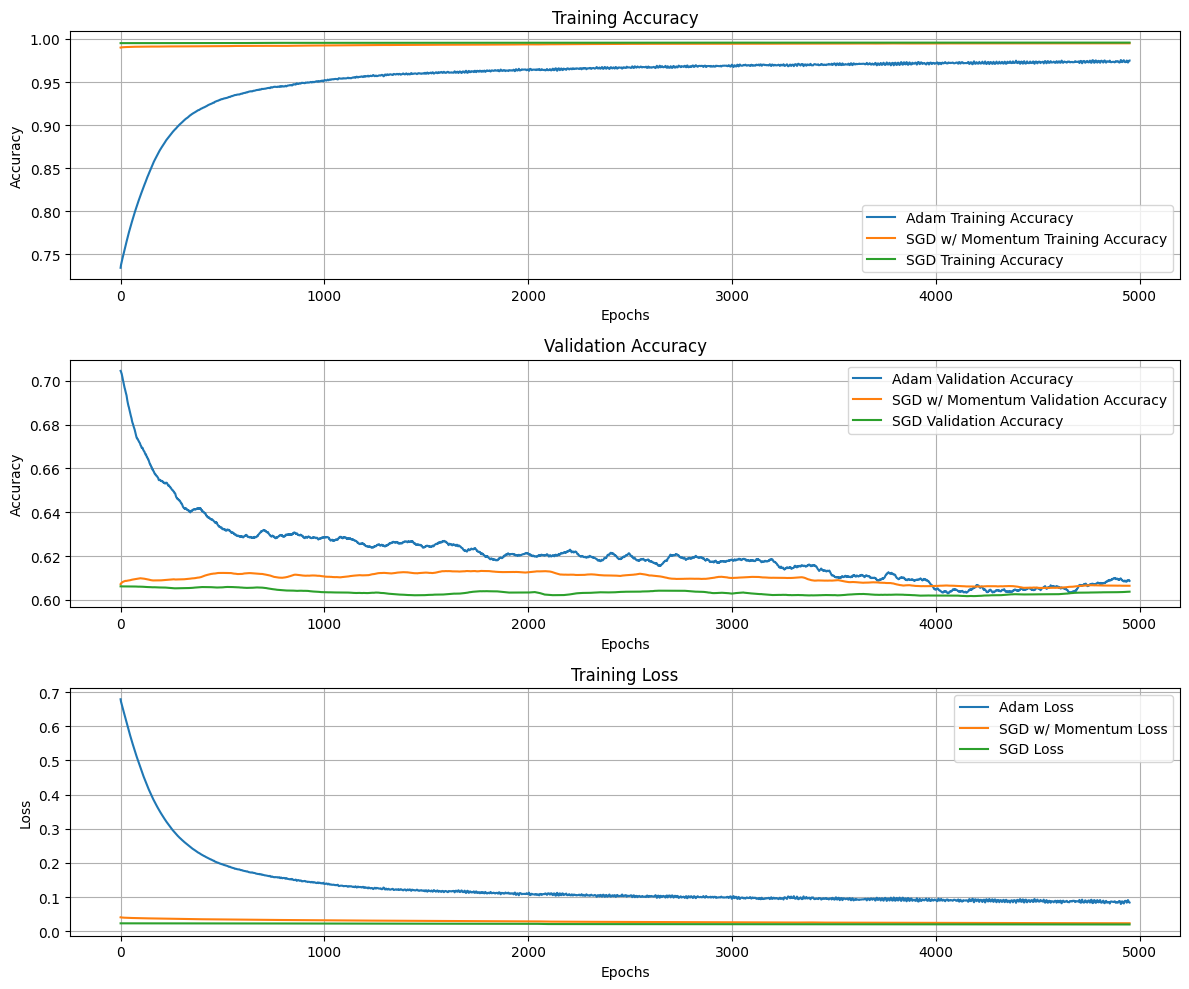

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(moving_average(history7['accuracy']), label='Adam Training Accuracy')
plt.plot(moving_average(history8['accuracy']), label='SGD w/ Momentum Training Accuracy')
plt.plot(moving_average(history9['accuracy']), label='SGD Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(moving_average(history7['val_accuracy']), label='Adam Validation Accuracy')
plt.plot(moving_average(history8['val_accuracy']), label='SGD w/ Momentum Validation Accuracy')
plt.plot(moving_average(history9['val_accuracy']), label='SGD Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(moving_average(history7['loss']), label='Adam Loss')
plt.plot(moving_average(history8['loss']), label='SGD w/ Momentum Loss')
plt.plot(moving_average(history9['loss']), label='SGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


RESULT
0    7140
2    1762
1    1098
Name: count, dtype: int64


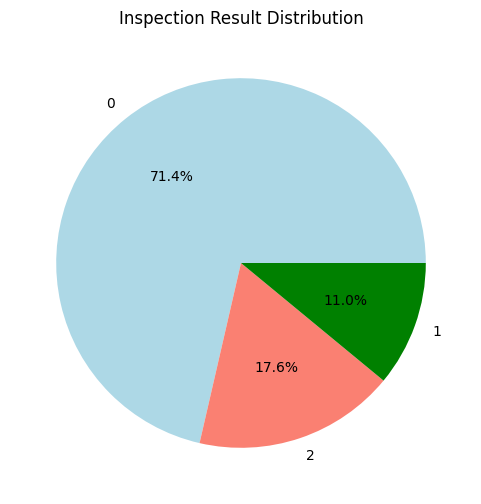

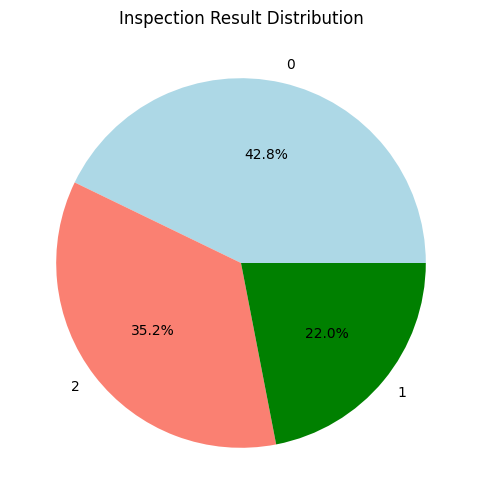

In [ ]:
insp_counts = df['RESULT'].value_counts()
print(insp_counts)
# Pie chart for inspection results
result_counts = df['RESULT'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', colors=['lightblue', 'salmon', 'green'])
plt.title('Inspection Result Distribution')
plt.show()

rows_with_zero = df[df['RESULT'] == 0]
rows_to_remove = rows_with_zero.sample(frac=0.7, random_state=42)
test = df.drop(rows_to_remove.index)

plt.figure(figsize=(6, 6))
plt.pie(test['RESULT'].value_counts(), labels=test['RESULT'].value_counts().index, autopct='%1.1f%%', colors=['lightblue', 'salmon', 'green'])
plt.title('Inspection Result Distribution')
plt.show()

In [ ]:
Xr = test.drop(columns=['RESULT', 'STREET_NAME', 'BOROUGH', 'INSPECTION_TYPE',
                     'HOUSE_NUMBER', 'NTA', 'LOCATION', 'INSPECTION_DATE'])

yr = test['RESULT']

X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr, yr, test_size=0.2, random_state=42)

scalerr = StandardScaler()
X_trainr = scalerr.fit_transform(X_trainr)
X_testr = scalerr.transform(X_testr)

# to categorical
y_trainr = tf.keras.utils.to_categorical(y_trainr, 3)
y_testr = tf.keras.utils.to_categorical(y_testr, 3)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_trainr.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes
])

optimizers = [Adam(learning_rate=0.001), SGD(learning_rate=0.001, momentum=0.5), SGD(learning_rate=0.001)]
initial_weights = model.get_weights()

for optimizer in enumerate(optimizers):
    print(f"Training with optimizer: {optimizer[1].name}")
    model.compile(optimizer=optimizer[1], loss='categorical_crossentropy', metrics=['accuracy'])
    model.set_weights(initial_weights)  # Reset to initial weights
    if optimizer[0] == 0:
      historyr1 = model.fit(X_trainr, y_trainr, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    elif optimizer[0] == 1:
      historyr2 = model.fit(X_trainr, y_trainr, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])
    else:
      historyr3 = model.fit(X_trainr, y_trainr, epochs=2000, batch_size=64, validation_split=0.2, verbose=0,callbacks=[CustomLogger()])


with open('historyr1.pkl', 'wb') as f:
    pickle.dump(historyr2.history, f)

with open('historyr2.pkl', 'wb') as f:
    pickle.dump(historyr2.history, f)

with open('historyr3.pkl', 'wb') as f:
    pickle.dump(historyr3.history, f)


ValueError: could not convert string to float: '112 SOUTH 2 STREET'

The above code was run locally. The output is attached -


```
Training with optimizer: adam
Epoch 100: Loss = 0.6345006823539734, Accuracy = 0.7230610251426697
Epoch 200: Loss = 0.4904237389564514, Accuracy = 0.7873836755752563
Epoch 300: Loss = 0.40837693214416504, Accuracy = 0.8304033279418945
Epoch 400: Loss = 0.35148435831069946, Accuracy = 0.851706326007843
Epoch 500: Loss = 0.3256165683269501, Accuracy = 0.8637021780014038
Epoch 600: Loss = 0.26907289028167725, Accuracy = 0.8982419967651367
Epoch 700: Loss = 0.23838256299495697, Accuracy = 0.9052740335464478
Epoch 800: Loss = 0.23030972480773926, Accuracy = 0.907755970954895
Epoch 900: Loss = 0.23219966888427734, Accuracy = 0.907755970954895
Epoch 1000: Loss = 0.19989803433418274, Accuracy = 0.9226473569869995
Epoch 1100: Loss = 0.2057054340839386, Accuracy = 0.9205791354179382
Epoch 1200: Loss = 0.2013944536447525, Accuracy = 0.9251292943954468
Epoch 1300: Loss = 0.15460972487926483, Accuracy = 0.9453981518745422
Epoch 1400: Loss = 0.15949894487857819, Accuracy = 0.9425025582313538
Epoch 1500: Loss = 0.13966234028339386, Accuracy = 0.9445708394050598
Epoch 1600: Loss = 0.1514243185520172, Accuracy = 0.946018636226654
Epoch 1700: Loss = 0.1425371915102005, Accuracy = 0.9495346546173096
Epoch 1800: Loss = 0.14111381769180298, Accuracy = 0.9464322924613953
Epoch 1900: Loss = 0.0986684113740921, Accuracy = 0.9656670093536377
Epoch 2000: Loss = 0.08861388266086578, Accuracy = 0.9706308245658875
Training with optimizer: SGD
Epoch 100: Loss = 0.9484236836433411, Accuracy = 0.5472595691680908
Epoch 200: Loss = 0.9296323657035828, Accuracy = 0.5638055801391602
Epoch 300: Loss = 0.9168407320976257, Accuracy = 0.5667011141777039
Epoch 400: Loss = 0.904742956161499, Accuracy = 0.5762150883674622
Epoch 500: Loss = 0.8931647539138794, Accuracy = 0.5822130441665649
Epoch 600: Loss = 0.8816030621528625, Accuracy = 0.5867632031440735
Epoch 700: Loss = 0.8694283366203308, Accuracy = 0.5958635210990906
Epoch 800: Loss = 0.8569734692573547, Accuracy = 0.6022750735282898
Epoch 900: Loss = 0.8434154987335205, Accuracy = 0.6117890477180481
Epoch 1000: Loss = 0.8289613723754883, Accuracy = 0.6179937720298767
Epoch 1100: Loss = 0.8138620853424072, Accuracy = 0.622130274772644
Epoch 1200: Loss = 0.7987639307975769, Accuracy = 0.6312305927276611
Epoch 1300: Loss = 0.7835105657577515, Accuracy = 0.6421923637390137
Epoch 1400: Loss = 0.7676687836647034, Accuracy = 0.652326762676239
Epoch 1500: Loss = 0.7516182661056519, Accuracy = 0.6560496091842651
Epoch 1600: Loss = 0.7358086705207825, Accuracy = 0.6703205704689026
Epoch 1700: Loss = 0.719395637512207, Accuracy = 0.678179919719696
Epoch 1800: Loss = 0.7024112343788147, Accuracy = 0.6930713653564453
Epoch 1900: Loss = 0.6851257085800171, Accuracy = 0.7009307146072388
Epoch 2000: Loss = 0.668313205242157, Accuracy = 0.7100310325622559
Training with optimizer: SGD
Epoch 100: Loss = 0.9692372679710388, Accuracy = 0.5329886078834534
Epoch 200: Loss = 0.948143720626831, Accuracy = 0.5478800535202026
Epoch 300: Loss = 0.9375657439231873, Accuracy = 0.5571871995925903
Epoch 400: Loss = 0.9292743802070618, Accuracy = 0.5615305304527283
Epoch 500: Loss = 0.9226054549217224, Accuracy = 0.5638055801391602
Epoch 600: Loss = 0.9165047407150269, Accuracy = 0.5691830515861511
Epoch 700: Loss = 0.9104806184768677, Accuracy = 0.5720785856246948
Epoch 800: Loss = 0.9045543074607849, Accuracy = 0.5770424008369446
Epoch 900: Loss = 0.8987352252006531, Accuracy = 0.5813857316970825
Epoch 1000: Loss = 0.8929778337478638, Accuracy = 0.5836607813835144
Epoch 1100: Loss = 0.8873708248138428, Accuracy = 0.5853154063224792
Epoch 1200: Loss = 0.8816269040107727, Accuracy = 0.5894519090652466
Epoch 1300: Loss = 0.875617265701294, Accuracy = 0.5921406149864197
Epoch 1400: Loss = 0.8695109486579895, Accuracy = 0.5964839458465576
Epoch 1500: Loss = 0.8632108569145203, Accuracy = 0.5981385707855225
Epoch 1600: Loss = 0.8566256761550903, Accuracy = 0.6041365265846252
Epoch 1700: Loss = 0.8500047326087952, Accuracy = 0.6076525449752808
Epoch 1800: Loss = 0.8430495262145996, Accuracy = 0.6128231883049011
Epoch 1900: Loss = 0.8360206484794617, Accuracy = 0.6148914098739624
Epoch 2000: Loss = 0.8287675380706787, Accuracy = 0.6177869439125061
```



In [ ]:
with open('historyr1.pkl', 'rb') as f:
    historyr1 = pickle.load(f)
with open('historyr2.pkl', 'rb') as f:
    historyr2 = pickle.load(f)
with open('historyr3.pkl', 'rb') as f:
    historyr3 = pickle.load(f)

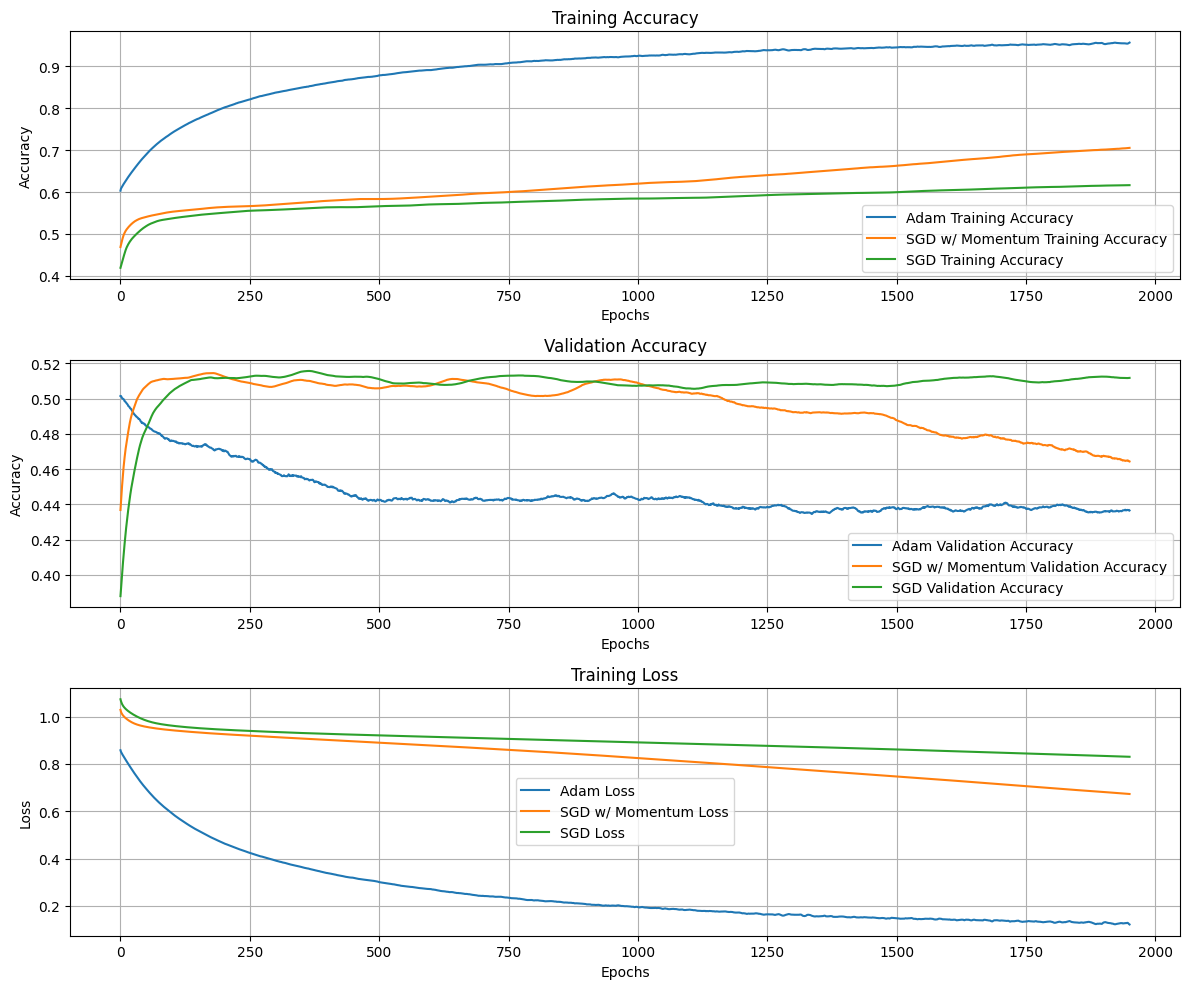

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(moving_average(historyr1['accuracy']), label='Adam Training Accuracy')
plt.plot(moving_average(historyr2['accuracy']), label='SGD w/ Momentum Training Accuracy')
plt.plot(moving_average(historyr3['accuracy']), label='SGD Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(moving_average(historyr1['val_accuracy']), label='Adam Validation Accuracy')
plt.plot(moving_average(historyr2['val_accuracy']), label='SGD w/ Momentum Validation Accuracy')
plt.plot(moving_average(historyr3['val_accuracy']), label='SGD Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(moving_average(historyr1['loss']), label='Adam Loss')
plt.plot(moving_average(historyr2['loss']), label='SGD w/ Momentum Loss')
plt.plot(moving_average(historyr3['loss']), label='SGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


After randomly removing items from the PASSED set to create a more even distribution in the data entry RESULTS, we rerun the fitting using each set of optimzers. We see that, while not a spectacular model fitting, that the Adam optimizer is better able to converge towards low loss / higher accuracy, while both SGD techniques converge at a slower rate. On top of this, we see that the SGD approach with momentum provides a marginal improvement over the no momentum implementation.

# (4) Tune Hyperparameters

In [ ]:
# from kerastuner.tuners import RandomSearch
# #hyper parameter tuning

# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32),
#                     activation='relu', input_shape=(X_train.shape[1],)))
#     model.add(Dense(units=hp.Int('units_hidden', min_value=32, max_value=128, step=32), activation='relu'))
#     model.add(Dense(3, activation='softmax'))
#     model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#                   loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='tuner_dir')
# tuner.search(X_train, y_train, epochs=10, validation_split=0.2)
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Hyperparameter tuning function
def build_model(hp):
    model = Sequential()

    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))

    model.add(Dense(units=hp.Int('units_hidden', min_value=32, max_value=128, step=32),
                    activation='relu', kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, step=1e-5))))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    # Learning rate scheduler
    lr_schedule = ExponentialDecay(initial_learning_rate=hp.Choice('initial_learning_rate', [1e-2, 1e-3]),
                                   decay_steps=100000, decay_rate=0.96, staircase=True)

    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Hyperparameter tuning with RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=3,
    directory='tuner_dir',
    overwrite=True  # make sure this is set to True to overwrite if needed
)

# Start hyperparameter search
tuner.search(X_train, y_train, epochs=3000, validation_split=0.2, callbacks=[early_stopping])


Trial 50 Complete [00h 00m 44s]
val_accuracy: 0.714305559794108

Best val_accuracy So Far: 0.7161111036936442
Total elapsed time: 00h 36m 37s

In [ ]:
#evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

## Summary

We were able to get a maximum validation accuracy of 0.7383.

One of the challenges we encountered is that our training data has a larger percent of "passed" inspection result and that it is difficult to train over a sufficiently large dataset without running into limitations in time and GPU usage limitations on google colab. If we were able to run it on a GPU for longer we would be able to try using more data and see if it helps our model overfitting.

Things we tried to do to improve our accuracy:

*   Dropping out "passed" inspection result so that the training dataset is   
    less biased towards "passed"
*   Increased the number of layers
*   Hyperparameter Tuning
*   Batch size
*   Trying different optimizers




